# Tarea 1
Integrantes:
- Felipe Olivares
- Beatriz Errázuriz

## 0. Manejo de datos

Para que funcione el Notebook, es necesario subir los 5 archivos al almacenamiento local de la sesión de ejecución y guardarlos en una carpeta dataset_tarea1. Estos archivos serían:
* dataset_tarea1/training_set.csv
* dataset_tarea1/validation_set.csv
* dataset_tarea1/rating_template_fill.csv
* dataset_tarea1/ranking_template_fill.json
* dataset_tarea1/items_styles.csv

In [ ]:
import pandas as pd
import json
import numpy as np
import os
import time
!mkdir dataset_tarea1

mkdir: cannot create directory ‘dataset_tarea1’: File exists


In [ ]:
training_set_path = 'dataset_tarea1/training_set.csv'
validation_set_path = 'dataset_tarea1/validation_set.csv'
rating_template_fill_path = 'dataset_tarea1/rating_template_fill.csv'
item_styles_path = 'dataset_tarea1/items_styles.csv'

item_styles = pd.read_csv(item_styles_path)
training_set = pd.read_csv(training_set_path)
validation_set = pd.read_csv(validation_set_path)
rating_template_fill = pd.read_csv(rating_template_fill_path, sep=';')
rating_template_fill.head()

,itemID,styleID,Rating,userID
0,39289,14756,NaN,715
1,3939,1417,NaN,4944
2,47695,14879,NaN,4890
3,7348,1199,NaN,5324
4,37403,1199,NaN,5544


In [ ]:
ranking_template_fill_path = 'dataset_tarea1/ranking_template_fill.json'

with open(ranking_template_fill_path, 'r') as file:
    ranking_template_fill = json.load(file)


Descargar librerías

In [ ]:
#@title Descargo Pyreclab, Matplotlib, SKLearn
!pip install pyreclab --upgrade
!pip install matplotlib --upgrade
!pip install implicit --upgrade
!pip install psutil
# !pip install sklearn --upgrade
# !pip install scikit-surprise --upgrade
# !pip install seaborn --upgrade

In [ ]:
import pyreclab
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import scipy.sparse as sparse
import implicit
import psutil
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import gc # memory management

Cambiar formato archivos

In [ ]:
training_set.columns

Index(['userID', 'itemID', 'styleID', 'rating'], dtype='object')

Filtrar columna styleID

In [ ]:
df_filtered_training = training_set[['userID', 'itemID', 'rating']]
df_filtered_training.loc[:, 'rating'] = df_filtered_training['rating'].astype(int)


filtered_training_csv_path = "dataset_tarea1/training_set_filtered.csv"
df_filtered_training.to_csv(filtered_training_csv_path, sep='\t', index=False, header=False)

In [ ]:
df_filtered_validation = validation_set[['userID', 'itemID', 'rating']]
df_filtered_validation.loc[:, 'rating'] = df_filtered_validation['rating'].astype(int)

filtered_validation_csv_path = "dataset_tarea1/validation_set_filtered.csv"
df_filtered_validation.to_csv(filtered_validation_csv_path, sep='\t', index=False, header=False)

Modificar `rating_template_fill`

In [ ]:
rating_template_fill_filtered = rating_template_fill[['userID', 'itemID', 'Rating']]
rating_template_fill_filtered.rename(columns={'Rating': 'rating'}, inplace=True)

<ipython-input-10-8af2c5b61706>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_template_fill_filtered.rename(columns={'Rating': 'rating'}, inplace=True)


# 1. Predicción de ratings

## 1.1 User-based Collaborative Filtering (UserKnn)

Declaramos objeto recomendador "myUserKnn".



In [ ]:
##### TESTEO DE TIEMPO DE EJECUCION Y CPU USAGE
# myUserKnn = pyreclab.UserKnn(dataset='dataset_tarea1/training_set_filtered.csv', dlmchar=b'\t', header=False, usercol=0, itemcol=1, ratingcol=2)
# # Iniciar el temporizador
# start_time = time.time()
# # Obtener el uso de CPU antes del entrenamiento
# cpu_usage_before = psutil.cpu_percent(interval=None)
# # Obtener información de memoria antes del entrenamiento
# mem_info_before = psutil.virtual_memory().used

# myUserKnn.train(k=5, similarity='pearson')

# # Obtener información de memoria después del entrenamiento
# mem_info_after = psutil.virtual_memory().used
# # Detener el temporizador
# end_time = time.time()
# # Obtener el uso de CPU después del entrenamiento
# cpu_usage_after = psutil.cpu_percent(interval=None)

# print(f"Tiempo de entrenamiento: {end_time - start_time} segundos")
# print(f"Memoria utilizada: {(mem_info_after - mem_info_before) / (1024 ** 2)} MB")
# print(f"Uso de CPU: {cpu_usage_after - cpu_usage_before}%")

**Iteración 1**
Iteramos sobre diferentes parametros de entrenamiento:

*   `k: neighbours = [5, 10, 25, 50, 70]`
*  `similarity: sims = ['pearson', 'cosine']`

Para este testeo obtuvimos mejores resultados con `k = 5 neighbours` y `sim = pearson`:
*    RMSE = 71.73%

Notamos que al disminuir el k, la simulación `pearson` va mejorando (disminuye el RMSE), mientras que al aumentar k, la simulación `cosine` va mejorando.

**Iteración 1.5**

Se realiza una iteración intermedia donde se revisa que sucede al hacer crecer sustancialmente el k:


*   disminuye el valor de RMSE de a muuuuuy poco
*   en ningún momento logra ser menor que para `k = 5`

**Iteración 2**

Procedemos a probar valores cercanos a `k = 5` y mayores que `k =  70` para encontrar un valor "optimo"


Segunda iteración:

*   `k: neighbours = [4, 5, 6, 8, 10]`
*  `similarity: sims = ['pearson', 'cosine']`


In [ ]:
# Primera iteración: [5, *10*, 25, 50, 70]
# neighbours = [5, 10, 25, 50, 70]

# Segunda iteración:
neighbours = [4, 5, 6, 8, 10]

sims = ['pearson', 'cosine']

# Crear lista de RMSE evaluados
rmse_eval_UKNN = []
rmse_graph_UKNN = [[],[]]

for neigh in neighbours:
  for sim in sims:
    print("-----------------------\nNeighbours: ", neigh, ", Similarity: ", sim)
    # Objeto Recomendador: UserKnn
    myUserKnn = pyreclab.UserKnn(dataset='dataset_tarea1/training_set_filtered.csv', dlmchar=b'\t', header=False, usercol=0, itemcol=1, ratingcol=2)

    # Entrenamiento
    myUserKnn.train(k=neigh, similarity=sim)

    # Crear una lista de predicciones
    predictions_UKNN = []
    pred_columns = ["userID", "itemID","prediction"]

    for index, row in rating_template_fill_filtered.iterrows():
        user_id = str(int(row['userID']))
        item_id = str(int(row['itemID']))

        try:
            pred = myUserKnn.predict(user_id, item_id)

        except ValueError:
            # Si el usuario o el item no existen en el modelo, se predice el promedio de las calificaciones por el usuario
            avg_user_rating = training_set[training_set['userID'] == int(user_id)]['rating'].mean()
            # print("Error. ItemId: ", item_id, ", AverageUserRating: ", avg_user_rating)
            pred = avg_user_rating

        finally:
          predictions_UKNN.append([int(user_id), int(item_id), pred])

    # Convertir resultados de prediccion a dataframe
    df_predictions_UKNN = pd.DataFrame(predictions_UKNN, columns=pred_columns)
    # df_predictions_UKNN.info()

    # mergeo resultados con validation set
    merged_df_UKNN = pd.merge(df_predictions_UKNN, df_filtered_validation, on=['userID', 'itemID'])
    rmse_UKNN = mean_squared_error(merged_df_UKNN['rating'], merged_df_UKNN['prediction'], squared=False)
    rmse_eval_UKNN.append([sim, neigh, rmse_UKNN])
    rmse_graph_UKNN[sims.index(sim)].append(rmse_UKNN)
    print("RMSE: ", rmse_UKNN)

    # free memory
    del(merged_df_UKNN)
    del(df_predictions_UKNN)
    del(predictions_UKNN)
    del(myUserKnn)
    gc.collect()


-----------------------
Neighbours:  4 , Similarity:  pearson
RMSE:  0.7648035851229072
-----------------------
Neighbours:  4 , Similarity:  cosine
RMSE:  0.9944950899501255
-----------------------
Neighbours:  5 , Similarity:  pearson
RMSE:  0.7173945250902014
-----------------------
Neighbours:  5 , Similarity:  cosine
RMSE:  0.9243612958180526
-----------------------
Neighbours:  6 , Similarity:  pearson
RMSE:  0.7970587018621168
-----------------------
Neighbours:  6 , Similarity:  cosine
RMSE:  0.8916234094227009
-----------------------
Neighbours:  8 , Similarity:  pearson
RMSE:  0.8407421986800271
-----------------------
Neighbours:  8 , Similarity:  cosine
RMSE:  0.9112975912572888
-----------------------
Neighbours:  10 , Similarity:  pearson
RMSE:  0.8559307106643022
-----------------------
Neighbours:  10 , Similarity:  cosine
RMSE:  0.9451651170872833


### Resultado UserKnn

Para este testeo obtuvimos mejores resultados con `k = 5 neighbours` y `sim = pearson`:
*    **RMSE = 71.73%**

Vale la pena notar que existe un mejor valor que se da para `k = 1` bajo la  `sim = pearson`, pero obviamos y excluimos este caso porque representa basicamente lanzar una moneda para obtener el resultado de la predicción, por lo que nos entrega un RMSE = 50.4%


**Tabla** con los valores RMSE obtenidos para los diferentes parámetros de `k neighbours` y `similarity function`.

Similarity,cosine,pearson
Neighbours,,
4,0.994495,0.764804
5,0.924361,0.717395
6,0.891623,0.797059
8,0.911298,0.840742
10,0.945165,0.855931


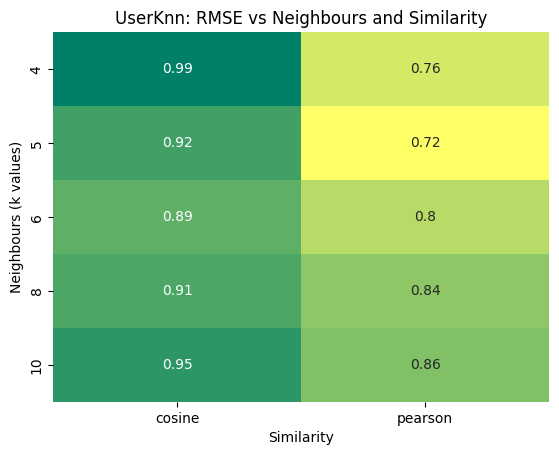

In [ ]:
# Primero se transforma en dataframe
rmse_eval_UKNN = pd.DataFrame(rmse_eval_UKNN, columns=['Similarity', 'Neighbours', 'RMSE'])
rmse_eval_UKNN['Similarity'] = rmse_eval_UKNN['Similarity'].replace({0: 'pearson', 1: 'cosine'})
# Re-estructuro de manera que tengo dos filas (pearson y cosine), tengo 5 columnas (5, 10, 25, 50, 70) y los valores son los rmse
rmse_table_UKNN = rmse_eval_UKNN.pivot(index='Similarity', columns='Neighbours', values='RMSE').T
plot = sns.heatmap(rmse_table_UKNN, annot=True, cmap=cm.summer_r, cbar=False)
plt.ylabel('Neighbours (k values)')
plt.xlabel('Similarity')
plt.title('UserKnn: RMSE vs Neighbours and Similarity')
fig = plot.get_figure()
fig.savefig("dataset_tarea1/heatmap_UKNN.png")
rmse_table_UKNN

**Gráfico** con gradiente de los valores RMSE obtenidos para los diferentes parámetros de `k neighbours` y `similarity function`.

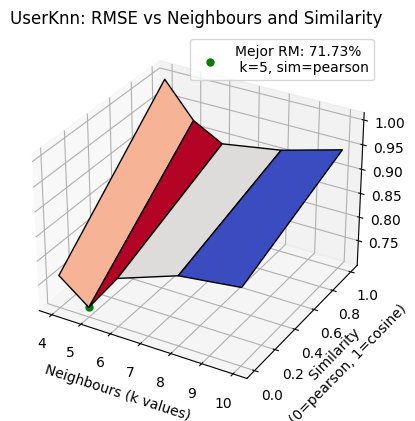

In [ ]:
rmse_data_UKNN = np.array(rmse_graph_UKNN)
x, y = np.meshgrid(np.array(neighbours), np.array([0, 1]))
# print(x), print(y), print(rmse_data_UKNN)

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
ax.plot_surface(x, y, rmse_data_UKNN,
                cmap=cm.coolwarm_r,
                edgecolors='black')
# Agrego punto en mejor valor (10 neighbours, 1 similarity-cosine)
ax.scatter(5, 0, 0.7173, color='green', marker='.', s=100, label='Mejor RM: 71.73%\n k=5, sim=pearson')
ax.legend()
plt.xlabel('Neighbours (k values)')
plt.ylabel('Similarity \n(0=pearson, 1=cosine)')
# plt.zlabel('RMSE')
plt.title('UserKnn: RMSE vs Neighbours and Similarity')
plt.show()

## 1.2  Item-based Collaborative Filtering (ItemKnn)

Declaramos objeto recomendador: ItemKnn.



In [ ]:
# # Ahora se declara durante las iteraciones para poder liberar la memoria entre cada iteracion.
# myItemKnn = pyreclab.ItemKnn(dataset='dataset_tarea1/training_set_filtered.csv', dlmchar=b'\t', header=False, usercol=0, itemcol=1, ratingcol=2)
# myItemKnn.train(k=10, similarity='pearson')

**Iteración 1**

Iteramos sobre diferentes parametros de entrenamiento:

*   `k: neighbours = [5, 10, 25, 50, 70]`
*  `similarity: sims = ['pearson', 'cosine']`

Para este testeo obtuvimos mejores resultados con `k = 10 neighbours` y `sim = pearson`:
*    RMSE = 59.23%

**Iteración 2**

Procedemos a probar valores cercanos a k=10 para encontrar un valor "optimo"

Segunda iteración:

*   `k: neighbours = [7, 8, 9, 10, 11]`
*  `similarity: sims = ['pearson', 'cosine']`

In [ ]:
# Primera iteración: [5, *10*, 25, 50, 70]
# neighbours = [5, 10, 25, 50, 70]
# Segunda iteración:
neighbours = [7, 8, 9, 10, 11]

sims = ['pearson', 'cosine']

# Crear lista de RMSE evaluados
rmse_eval_IKNN = []
rmse_graph_IKNN = [[],[]]

for neigh in neighbours:
  for sim in sims:
    print("-----------------------\nNeighbours: ", neigh, ", Similarity: ", sim)
    # Objeto Recomendador: ItemKnn
    myItemKnn = pyreclab.ItemKnn(dataset='dataset_tarea1/training_set_filtered.csv', dlmchar=b'\t', header=False, usercol=0, itemcol=1, ratingcol=2)

    # Entrenamiento
    myItemKnn.train(k=neigh, similarity=sim)

    # Crear una lista de predicciones
    predictions_IKNN = []
    pred_columns = ["userID", "itemID","prediction"]

    for index, row in rating_template_fill_filtered.iterrows():
        user_id = str(int(row['userID']))
        item_id = str(int(row['itemID']))

        try:
            pred = myItemKnn.predict(user_id, item_id)

        except ValueError:
            # Si el usuario o el item no existen en el modelo, se predice el promedio de las calificaciones por el usuario
            avg_user_rating = training_set[training_set['userID'] == int(user_id)]['rating'].mean()
            # print("Error. ItemId: ", item_id, ", AverageUserRating: ", avg_user_rating)
            pred = avg_user_rating

        finally:
          predictions_IKNN.append([int(user_id), int(item_id), pred])

    # Convertir resultados de prediccion a dataframe
    df_predictions_IKNN = pd.DataFrame(predictions_IKNN, columns=pred_columns)
    # df_predictions_IKNN.info()

    # mergeo resultados con validation set
    merged_df_IKNN = pd.merge(df_predictions_IKNN, df_filtered_validation, on=['userID', 'itemID'])
    rmse_IKNN = mean_squared_error(merged_df_IKNN['rating'], merged_df_IKNN['prediction'], squared=False)
    rmse_eval_IKNN.append([sim, neigh, rmse_IKNN])
    rmse_graph_IKNN[sims.index(sim)].append(rmse_IKNN)
    print("RMSE: ", rmse_IKNN)

    # free memory
    del(merged_df_IKNN)
    del(df_predictions_IKNN)
    del(predictions_IKNN)
    del(myItemKnn)
    gc.collect()


-----------------------
Neighbours:  7 , Similarity:  pearson
RMSE:  0.593232345238691
-----------------------
Neighbours:  7 , Similarity:  cosine
RMSE:  0.6812290686295944
-----------------------
Neighbours:  8 , Similarity:  pearson
RMSE:  0.5964124294773449
-----------------------
Neighbours:  8 , Similarity:  cosine
RMSE:  0.6891992406374055
-----------------------
Neighbours:  9 , Similarity:  pearson
RMSE:  0.5940391387224148
-----------------------
Neighbours:  9 , Similarity:  cosine
RMSE:  0.6776101361204498
-----------------------
Neighbours:  10 , Similarity:  pearson
RMSE:  0.5923313055334293
-----------------------
Neighbours:  10 , Similarity:  cosine
RMSE:  0.6960255177897671
-----------------------
Neighbours:  11 , Similarity:  pearson
RMSE:  0.5920804399503065
-----------------------
Neighbours:  11 , Similarity:  cosine
RMSE:  0.7020320235875308


Para este testeo obtuvimos mejores resultados con `k = 10 neighbours` y `sim = pearson`:
*    RMSE = 59.23%

**Tabla** con los valores RMSE obtenidos para los diferentes parámetros de `k neighbours` y `similarity function`.

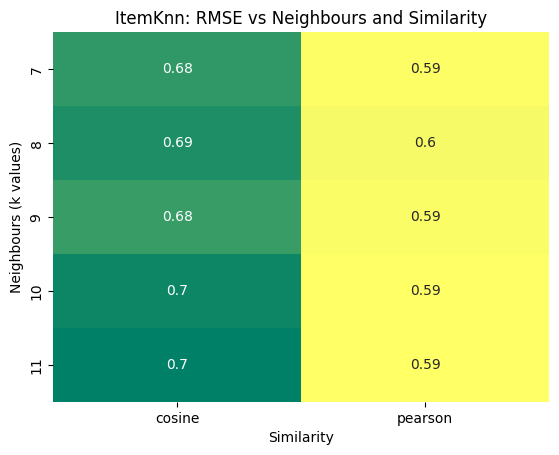

In [ ]:
# Primero se transforma en dataframe
rmse_eval_IKNN = pd.DataFrame(rmse_eval_IKNN, columns=['Similarity', 'Neighbours', 'RMSE'])
rmse_eval_IKNN['Similarity'] = rmse_eval_IKNN['Similarity'].replace({0: 'pearson', 1: 'cosine'})
# Re-estructuro de manera que tengo dos filas (pearson y cosine), tengo 5 columnas (5, 10, 25, 50, 70) y los valores son los rmse
rmse_table_IKNN = rmse_eval_IKNN.pivot(index='Similarity', columns='Neighbours', values='RMSE').T
plot_IKNN = sns.heatmap(rmse_table_IKNN, annot=True, cmap=cm.summer_r, cbar=False)
plt.ylabel('Neighbours (k values)')
plt.xlabel('Similarity')
plt.title('ItemKnn: RMSE vs Neighbours and Similarity')
fig_IKNN = plot_IKNN.get_figure()
fig_IKNN.savefig("dataset_tarea1/heatmap_IKNN.png")

**Gráfico** con los valores RMSE obtenidos para los diferentes parámetros de `k neighbours` y `similarity function`.

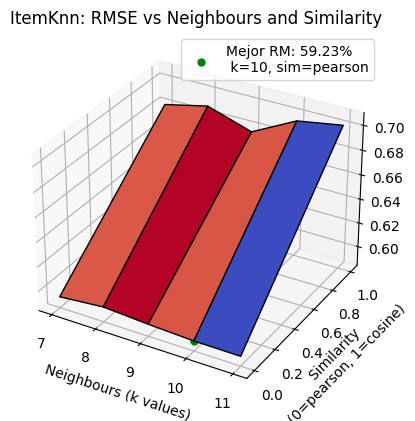

In [ ]:
rmse_data_IKNN = np.array(rmse_graph_IKNN)
x, y = np.meshgrid(np.array(neighbours), np.array([0, 1]))
# print(x), print(y), print(rmse_data_IKNN)

fig_IKNN = plt.figure()
ax_IKNN = fig_IKNN.add_subplot(1,1,1, projection='3d')
ax_IKNN.plot_surface(x, y, rmse_data_IKNN,
                cmap=cm.coolwarm_r,
                edgecolors='black')
# Agrego punto en mejor valor (10 neighbours, 1 similarity-cosine)
ax_IKNN.scatter(10, 0, 0.5923, color='green', marker='.', s=100, label='Mejor RM: 59.23%\n k=10, sim=pearson')
ax_IKNN.legend()
plt.xlabel('Neighbours (k values)')
plt.ylabel('Similarity \n(0=pearson, 1=cosine)')
# plt.zlabel('RMSE')
plt.title('ItemKnn: RMSE vs Neighbours and Similarity')
plt.show()

## 1.3 Funk SVD

Declaramos objeto recomendador: FunkSVD.



In [ ]:
# # Ahora se declara durante las iteraciones para poder liberar la memoria entre cada iteracion.
# mySVD = pyreclab.SVD(dataset='dataset_tarea1/training_set_filtered.csv', dlmchar=b'\t', header=False, usercol=0, itemcol=1, ratingcol=2)
# mySVD.train(factors=140, maxiter=90, lr=0.011, lamb=0.065)

**Iteración 1**

Iteramos sobre diferentes parametros de entrenamiento:

*   `Factors: f = [50, 100, 150]`
*  `MaxIterations: mi = [50, 100, 150]`
*   `rates: lr = [0.005, 0.01, 0.05]`
*  `Lambda: lamb = [0.01, 0.05, 0.1]`

Para este testeo obtuvimos mejores resultados con `f = 100`, `mi = 50`, `lr = 0.01`,  y `lamb = 0.1`:
*    RMSE = 66.83%

Y segundo mejor resultado con `f = 150`, `mi = 100`, `lr = 0.01`,  y `lamb = 0.05`:
*    RMSE = 67.94%

**Iteración 2**

Procedemos a probar valores cercanos a nuestro **Mejor Resultado** de la iteración 1:

*   `Factors: f = [90, 105, 115]`
*  `MaxIterations: mi = [40, 55, 65]`
*   `rates: lr = [0.008, 0.011, 0.015]`
*  `Lambda: lamb = [0.06, 0.08, 0.11]`

**Iteración 3**

Procedemos a probar valores cercanos a nuestro **Segundo Mejor Resultado** de la iteración 1:

*   `Factors: f = [140, 155, 165]`
*  `MaxIterations: mi = [90, 105, 115]`
*   `rates: lr = [0.008, 0.011, 0.015]`
*  `Lambda: lamb = [0.04, 0.06, 0.065]`

In [ ]:
# Tercera Iteración:
factors = [140, 155, 165]
maxiters = [90, 105, 115]
rates = [0.008, 0.011, 0.015]
lambdas = [0.04, 0.06, 0.065]


# Crear lista de RMSE evaluados
rmse_eval_SVD = []
# Crear lista de RMSE para graficar: [Lambda][LearningRates][MaxIters][Factors]
rmse_graph_SVD = [[[[],[],[]],[[],[],[]],[[],[],[]]],[[[],[],[]],[[],[],[]],[[],[],[]]],[[[],[],[]],[[],[],[]],[[],[],[]]]]

for fact in factors:
  for mi in maxiters:
    for lr in rates:
      for lamb in lambdas:
        print("-----------------------\nFactors: ", fact, ", MaxIter: ", mi, ", LearningRate: ", lr, ", Lambda: ", lamb)
        # Objeto Recomendador: SVD
        mySVD = pyreclab.SVD(dataset='dataset_tarea1/training_set_filtered.csv', dlmchar=b'\t', header=False, usercol=0, itemcol=1, ratingcol=2)

        # Entrenamiento
        mySVD.train(factors=fact, maxiter=mi, lr=lr, lamb=lamb)

        # Crear una lista de predicciones
        predictions_SVD = []
        pred_columns = ["userID", "itemID","prediction"]

        for index, row in rating_template_fill_filtered.iterrows():
            user_id = str(int(row['userID']))
            item_id = str(int(row['itemID']))

            try:
                pred = mySVD.predict(user_id, item_id)

            except ValueError:
                # Si el usuario o el item no existen en el modelo, se predice el promedio de las calificaciones por el usuario
                avg_user_rating = training_set[training_set['userID'] == int(user_id)]['rating'].mean()
                # print("Error. ItemId: ", item_id, ", UserId: ", user_id, ", AverageUserRating: ", avg_user_rating)
                pred = avg_user_rating

            finally:
              predictions_SVD.append([int(user_id), int(item_id), pred])

        # Convertir resultados de prediccion a dataframe
        df_predictions_SVD = pd.DataFrame(predictions_SVD, columns=pred_columns)
        # df_predictions_SVD.info()

        # mergeo resultados con validation set
        merged_df_SVD = pd.merge(df_predictions_SVD, df_filtered_validation, on=['userID', 'itemID'])
        rmse_SVD = mean_squared_error(merged_df_SVD['rating'], merged_df_SVD['prediction'], squared=False)
        rmse_eval_SVD.append([fact, mi, lr, lamb, rmse_SVD])
        rmse_graph_SVD[lambdas.index(lamb)][rates.index(lr)][maxiters.index(mi)].append(rmse_SVD)
        print("RMSE: ", rmse_SVD)

        # free memory
        del(merged_df_SVD)
        del(df_predictions_SVD)
        del(predictions_SVD)
        del(mySVD)
        gc.collect()


-----------------------
Factors:  140 , MaxIter:  90 , LearningRate:  0.008 , Lambda:  0.04
RMSE:  0.7641362489408025
-----------------------
Factors:  140 , MaxIter:  90 , LearningRate:  0.008 , Lambda:  0.06
RMSE:  0.7453024089420095
-----------------------
Factors:  140 , MaxIter:  90 , LearningRate:  0.008 , Lambda:  0.065
RMSE:  0.7859101660087288
-----------------------
Factors:  140 , MaxIter:  90 , LearningRate:  0.011 , Lambda:  0.04
RMSE:  0.790525483192142
-----------------------
Factors:  140 , MaxIter:  90 , LearningRate:  0.011 , Lambda:  0.06
RMSE:  0.8129263963183138
-----------------------
Factors:  140 , MaxIter:  90 , LearningRate:  0.011 , Lambda:  0.065
RMSE:  0.7372114326847856
-----------------------
Factors:  140 , MaxIter:  90 , LearningRate:  0.015 , Lambda:  0.04
RMSE:  0.785644345797205
-----------------------
Factors:  140 , MaxIter:  90 , LearningRate:  0.015 , Lambda:  0.06
RMSE:  0.7631673542001548
-----------------------
Factors:  140 , MaxIter:  90 , L

In [ ]:
# Obtener el mejor RMSE (mayor valor)
rmse_df_SVD = pd.DataFrame(rmse_eval_SVD, columns=['Factors', 'MaxIter', 'LearningRate', 'Lambda', 'RMSE'])
rmse_df_SVD.sort_values(by='RMSE', ascending=True, inplace=True)
rmse_df_SVD.head()

,Factors,MaxIter,LearningRate,Lambda,RMSE
60,165,90,0.015,0.040,0.632088
74,165,115,0.008,0.065,0.711479
13,140,105,0.011,0.060,0.714873
69,165,105,0.015,0.040,0.724076
8,140,90,0.015,0.065,0.728596


Luego de las **iteraciones 2 y 3**, el mejor conjunto de parámetros encontrado fue:

*   `Factors: f = 140`
*  `MaxIterations: mi = 90`
*   `rates: lr = 0.011`
*  `Lambda: lamb = 0.065`
* **RMSE = 67.94%**

con menciones honrosas para:

*   Mejor combinación Iteración 2: `f = 90, mi = 55, lr = 0.008, lamb = 0.06` con `RMSE = 70.88%`
*   Segunda combinación Iteración 3: `f = 140, mi = 90, lr = 0.008, lamb = 0.065` con `RMSE = 68.61%`

### Iteración 4
Procedo a hacer un test de sensibilidad  para valores de *Factors* y *MaxIterations*, manteniendo `LearningRate = 0.011` y `Lambda = 0.065`.

Los parametros a probar y luego graficar son:
* Factors: f = [135, 140, 145, 150, 155]
* MaxIteraciones: mi = [85, 90, 95, 100, 105]

In [ ]:
# Tercera Iteración:
factors = [135, 140, 145, 150, 155]
maxiters = [85, 90, 95, 100, 105]
rates = 0.011
lambdas = 0.065


# Crear lista de RMSE evaluados
rmse_eval_SVD = []
# Crear lista de RMSE para graficar:[MaxIters][Factors]
rmse_graph_SVD = [[],[],[],[],[]]

for fact in factors:
  for mi in maxiters:
    print("-----------------------\nFactors: ", fact, ", MaxIter: ", mi, ", LearningRate: ", lr, ", Lambda: ", lamb)
    # Objeto Recomendador: SVD
    mySVD = pyreclab.SVD(dataset='dataset_tarea1/training_set_filtered.csv', dlmchar=b'\t', header=False, usercol=0, itemcol=1, ratingcol=2)

    # Entrenamiento
    mySVD.train(factors=fact, maxiter=mi, lr=rates, lamb=lambdas)

    # Crear una lista de predicciones
    predictions_SVD = []
    pred_columns = ["userID", "itemID","prediction"]

    for index, row in rating_template_fill_filtered.iterrows():
        user_id = str(int(row['userID']))
        item_id = str(int(row['itemID']))

        try:
            pred = mySVD.predict(user_id, item_id)

        except ValueError:
            # Si el usuario o el item no existen en el modelo, se predice el promedio de las calificaciones por el usuario
            avg_user_rating = training_set[training_set['userID'] == int(user_id)]['rating'].mean()
            # print("Error. ItemId: ", item_id, ", UserId: ", user_id, ", AverageUserRating: ", avg_user_rating)
            pred = avg_user_rating

        finally:
          predictions_SVD.append([int(user_id), int(item_id), pred])

    # Convertir resultados de prediccion a dataframe
    df_predictions_SVD = pd.DataFrame(predictions_SVD, columns=pred_columns)
    # df_predictions_SVD.info()

    # mergeo resultados con validation set
    merged_df_SVD = pd.merge(df_predictions_SVD, df_filtered_validation, on=['userID', 'itemID'])
    rmse_SVD = mean_squared_error(merged_df_SVD['rating'], merged_df_SVD['prediction'], squared=False)
    rmse_eval_SVD.append([fact, mi, rmse_SVD])
    rmse_graph_SVD[maxiters.index(mi)].append(rmse_SVD)
    print("RMSE: ", rmse_SVD)

    # free memory
    del(merged_df_SVD)
    del(df_predictions_SVD)
    del(predictions_SVD)
    del(mySVD)
    gc.collect()


-----------------------
Factors:  135 , MaxIter:  85 , LearningRate:  0.015 , Lambda:  0.065
RMSE:  0.7389000483836985
-----------------------
Factors:  135 , MaxIter:  90 , LearningRate:  0.015 , Lambda:  0.065
RMSE:  0.7668655074432353
-----------------------
Factors:  135 , MaxIter:  95 , LearningRate:  0.015 , Lambda:  0.065
RMSE:  0.6936615873740525
-----------------------
Factors:  135 , MaxIter:  100 , LearningRate:  0.015 , Lambda:  0.065
RMSE:  0.7614726380025547
-----------------------
Factors:  135 , MaxIter:  105 , LearningRate:  0.015 , Lambda:  0.065
RMSE:  0.7426569786043665
-----------------------
Factors:  140 , MaxIter:  85 , LearningRate:  0.015 , Lambda:  0.065
RMSE:  0.8922231274304206
-----------------------
Factors:  140 , MaxIter:  90 , LearningRate:  0.015 , Lambda:  0.065
RMSE:  0.7961143874711611
-----------------------
Factors:  140 , MaxIter:  95 , LearningRate:  0.015 , Lambda:  0.065
RMSE:  0.7223182987171956
-----------------------
Factors:  140 , MaxIte

**Tabla** con los valores RMSE obtenidos para los diferentes parámetros de `k neighbours` y `similarity function`.

In [ ]:
# Obtener el mejor RMSE (mayor valor)
rmse_df_SVD = pd.DataFrame(rmse_eval_SVD, columns=['Factors', 'MaxIter', 'RMSE'])
rmse_df_SVD.sort_values(by='RMSE', ascending=True, inplace=True)
rmse_df_SVD.head()

,Factors,MaxIter,RMSE
2,135,95,0.693662
11,145,90,0.711832
7,140,95,0.722318
24,155,105,0.724813
0,135,85,0.738900


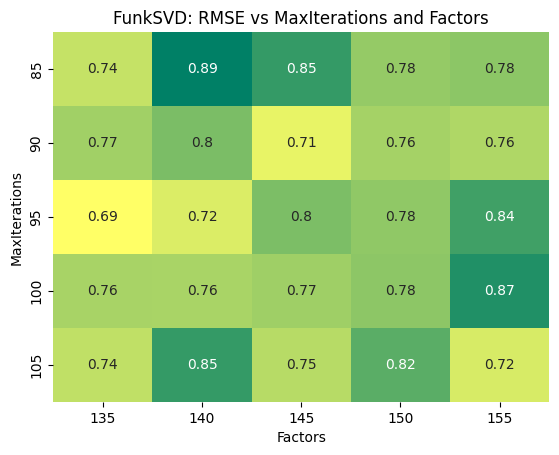

In [ ]:
# Primero se transforma en dataframe
rmse_eval_SVD = pd.DataFrame(rmse_eval_SVD, columns=['Factors', 'MaxIterations', 'RMSE'])
# Re-estructuro de manera que tengo dos filas (pearson y cosine), tengo 5 columnas (5, 10, 25, 50, 70) y los valores son los rmse
rmse_table_SVD = rmse_eval_SVD.pivot(index='Factors', columns='MaxIterations', values='RMSE').T
plot_SVD = sns.heatmap(rmse_table_SVD, annot=True, cmap=cm.summer_r, cbar=False)
plt.ylabel('MaxIterations')
plt.xlabel('Factors')
plt.title('FunkSVD: RMSE vs MaxIterations and Factors')
fig_SVD = plot_SVD.get_figure()
fig_SVD.savefig("dataset_tarea1/heatmap_SVD.png")

**Gráfico** con los valores RMSE obtenidos para los diferentes parámetros de `Factors` y `MaxIterations`.

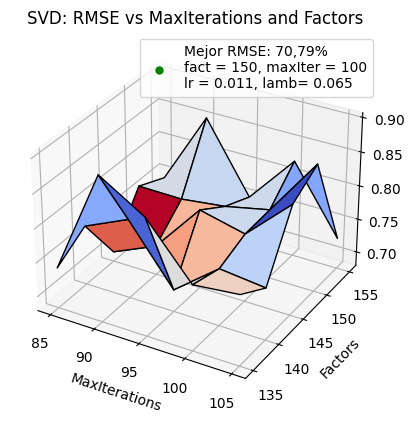

In [ ]:
rmse_data_SVD = np.array(rmse_graph_SVD)
x, y = np.meshgrid(np.array(maxiters), np.array(factors))
# print(x), print(y), print(rmse_data_SVD)

fig_SVD = plt.figure()
ax_SVD = fig_SVD.add_subplot(1,1,1, projection='3d')
ax_SVD.plot_surface(x, y, rmse_data_SVD,
                cmap=cm.coolwarm_r,
                edgecolors='black')
# Agrego punto en mejor valor
ax_SVD.scatter(100, 150, 0.7079, color='green', marker='.', s=100, label='Mejor RMSE: 70,79%\nfact = 150, maxIter = 100\nlr = 0.011, lamb= 0.065')
ax_SVD.legend()
plt.xlabel('MaxIterations')
plt.ylabel('Factors')
# plt.zlabel('RMSE')
plt.title('SVD: RMSE vs MaxIterations and Factors')
plt.show()

##1.4 Conclusión de Predicciones y Análisis

Para concluir la sección de predicciones, el **mejor de todos los modelos** entrenados durante las iteraciones de *UserKnn*, *ItemKnn* y *FunkSVD* fue:

*    #### ItemKnn con parametros `k = 10 vecinos` y `sim = pearson` obteniendo un `RMSE = 59.23%`

Como análisis principal, resalto el echo de que **ningúno** de nuestros modelos entrenados **logró disminuir el RMSE por debajo del 50%**, lo cuál son resultados desepcionantes. Por otro lado, es relevante notar que para todos los modelos que entrenamos usamos un supuesto que puede haber aumentado sustancialmente el error obtenido.

Este supuesto es que para los casos en que el `itemID` o el `userID` no existan dentro del *training_set*, entonces:
1. Como el modelo no puede predecir en estos casos,
2. entonces se utiliza el promedio de los ratings del usuario con `userID` como rating para ese `itemID`.

Ese promedio de ratings era en varias ocaciones obtenido de un solo rating histórico que había almacenado para el usuario lo cuál fácilmente puede haber sido la causa principal del error obtenido.

Finalmente, procedemos a ejecutar este modelo y guardar los resultados de predicción obtenidos en el archivo `rating_template_fill_FINAL.csv` y `rating_template_fill.csv`

In [ ]:
## ENTRENAMIENTO FINAL ##
# Objeto Recomendador: ItemKnn
myItemKnn = pyreclab.ItemKnn(dataset='dataset_tarea1/training_set_filtered.csv', dlmchar=b'\t', header=False, usercol=0, itemcol=1, ratingcol=2)

# Entrenamiento
myItemKnn.train(k=10, similarity='pearson')

## PREDICCION FINAL ##
# Crear una lista de predicciones
predictions_FINAL = []
pred_columns = ["userID", "itemID","prediction"]

for index, row in rating_template_fill_filtered.iterrows():
    user_id = str(int(row['userID']))
    item_id = str(int(row['itemID']))

    try:
        pred = myItemKnn.predict(user_id, item_id)

    except ValueError:
        # Si el usuario o el item no existen en el modelo, se predice el promedio de las calificaciones por el usuario
        avg_user_rating = training_set[training_set['userID'] == int(user_id)]['rating'].mean()
        # print("Error. ItemId: ", item_id, ", AverageUserRating: ", avg_user_rating)
        pred = avg_user_rating

    finally:
      predictions_FINAL.append([int(user_id), int(item_id), pred])

# Convertir resultados de prediccion a dataframe
df_predictions_FINAL = pd.DataFrame(predictions_FINAL, columns=pred_columns)
# df_predictions_FINAL.info()

## ESCRITURA FINAL ##
# Create a copy of rating_template_fill
rating_template_fill_FINAL = rating_template_fill.copy()

# Modify the 'rating' column with the values from predictions for each 'userID', 'itemID' value
rating_template_fill_FINAL['Rating'] = df_predictions_FINAL['prediction']
rating_template_fill['Rating'] = df_predictions_FINAL['prediction']

FINAL_path = 'dataset_tarea1/rating_template_fill_FINAL.csv'
rating_template_fill_FINAL.to_csv(FINAL_path, sep=';', index=False, header=True)

fill_path = 'dataset_tarea1/rating_template_fill.csv'
rating_template_fill.to_csv(fill_path, sep=';', index=False, header=True)

rating_template_fill.head()

,itemID,styleID,Rating,userID
0,39289,14756,3.640728,715
1,3939,1417,3.492556,4944
2,47695,14879,3.583643,4890
3,7348,1199,4.183487,5324
4,37403,1199,3.646022,5544


#2. Recomendación de ítems

### 2.0 Metricas de los modelo

In [ ]:
def calcular_diversidad(item_styles, ranking):
      item_categories = item_styles.set_index('itemID')['styleID'].to_dict()
      categorias_recomendadas = [item_categories[item] for item in ranking if item in item_categories]

      # Calcular la proporción de categorías únicas
      categorias_unicas = len(set(categorias_recomendadas))
      diversidad = categorias_unicas / len(ranking)

      return diversidad


In [ ]:
item_counts = training_set['itemID'].value_counts()
total_interacciones = len(training_set)
items_popularity = item_counts / total_interacciones
items_popularity = items_popularity.to_dict()

In [ ]:
def calcular_novedad(recomendaciones_usuarios):
    num_usuarios = len(recomendaciones_usuarios)
    novedad_total = 0

    for usuario, recomendaciones in recomendaciones_usuarios.items():
        novedad_usuario = 0

        for item in recomendaciones:
            # Verifica si el item está en items_popularity
            if int(item) in items_popularity:
                novedad_usuario += np.log(1 / items_popularity[int(item)])

        # Evitar división por cero en caso de que no haya recomendaciones
        if len(recomendaciones) > 0:
            novedad_total += novedad_usuario / len(recomendaciones)

    # Evitar división por cero en caso de que no haya usuarios
    if num_usuarios > 0:
        novedad_promedio = novedad_total / num_usuarios
    else:
        novedad_promedio = 0

    return novedad_promedio

## 2.1. Item Based Collaborative Filtering

In [ ]:
##### EL SIGUIENTE MODELO SE DEMORO MAS DE 2 HORAS EN UN 20% DE LA EJECUCIÓN #####
##### POR ESO NO ESTA EJECUTADO zzz #####

# Definir los rangos de parámetros que quieres probar
neighbours = [7, 8, 9, 10, 11]
sims = ['pearson', 'cosine']
top_n = 10  # Número de recomendaciones a considerar para la evaluación

best_map = -1  # Inicializar con un valor bajo para MAP
best_ndcg = -1  # Inicializar con un valor bajo para NDCG
best_params = None

for neigh in neighbours:
  for sim in sims:
    print("-----------------------\nNeighbours: ", neigh, ", Similarity: ", sim)
    # Objeto Recomendador: ItemKnn
    myModel = pyreclab.ItemKnn(dataset='dataset_tarea1/training_set_filtered.csv', dlmchar=b'\t', header=False, usercol=0, itemcol=1, ratingcol=2)

    # Entrenamiento
    myModel.train(k=neigh, similarity=sim)

    recommendList, mean_map, mean_ndcg = myModel.testrec(input_file='dataset_tarea1/validation_set.csv',
                                dlmchar=b',',
                                header=False,
                                usercol=0,
                                itemcol=1,
                                ratingcol=3,
                                topn=top_n,
                                relevance_threshold=2,
                                includeRated=False)

    # Imprimir las métricas para cada combinación
    print(f"Neighbors={neigh} | Sim={sim} | MAP: {mean_map:.4f} | NDCG: {mean_ndcg:.4f}")

    # Comparar y guardar los mejores resultados
    if mean_map > best_map and mean_ndcg > best_ndcg:
        best_map = mean_map
        best_ndcg = mean_ndcg
        best_params = (neigh,sim)

# Mostrar la mejor combinación de parámetros
print(f"Mejor combinación de parámetros: Neighbors={best_params[0]}, Sim={best_params[1]} con MAP: {best_map:.4f} y NDCG: {best_ndcg:.4f}")

In [ ]:
myItemKnn = pyreclab.ItemKnn(dataset='dataset_tarea1/training_set_filtered.csv', dlmchar=b'\t', header=False, usercol=0, itemcol=1, ratingcol=2)
# Iniciar el temporizador
start_time = time.time()
# Obtener información de memoria antes del entrenamiento
mem_info_before = psutil.virtual_memory().used
# Obtener el uso de CPU antes del entrenamiento
cpu_usage_before = psutil.cpu_percent(interval=None)

myItemKnn.train(k=10, similarity='pearson')

# Obtener información de memoria después del entrenamiento
mem_info_after = psutil.virtual_memory().used
# Detener el temporizador
end_time = time.time()
# Obtener el uso de CPU después del entrenamiento
cpu_usage_after = psutil.cpu_percent(interval=None)

print(f"Tiempo de entrenamiento: {end_time - start_time} segundos")
print(f"Memoria utilizada: {(mem_info_after - mem_info_before) / (1024 ** 2)} MB")
print(f"Uso de CPU: {cpu_usage_after - cpu_usage_before}%")

In [ ]:
top_n = 10

recommendList, maprec, ndcg = myItemKnn.testrec(input_file='dataset_tarea1/validation_set.csv',
                                          dlmchar=b',',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=3,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

In [ ]:
ranking_IKNN = {}
recall_score = 0
diversidad = 0

for user_id in ranking_template_fill.keys():
    recommendations = myItemKnn.recommend(str(user_id), 10, includeRated=False)
    ranking = [int(r) for r in recommendations]
    recall = myItemKnn.recall(str(user_id), ranking)
    diversidad += calcular_diversidad(item_styles, ranking)
    if not np.isnan(recall):
      recall_score += recall
    ranking_IKNN[user_id] = recommendations

print('Recall del dataset: {}'.format(recall_score / len(ranking_template_fill)))
print('Diversidad: {}'.format(diversidad / len(ranking_template_fill)))

In [ ]:
novedad = calcular_novedad(ranking_IKNN)
print('Novedad: {}'.format(novedad))

In [ ]:
with open('dataset_tarea1/ranking_template_fill_IKNN.json', 'w') as file:
    json.dump(ranking_IKNN, file, indent=2)


## 2.2. Funk SVD

In [ ]:
from implicit.bpr import BayesianPersonalizedRanking
import numpy as np

# Definir los rangos de parámetros que quieres probar
factors_list = [40, 50, 70]
learning_rates = [0.001, 0.01, 0.1]
lambdas = [0.065, 0.05, 0.1, 0.5]
top_n = 10  # Número de recomendaciones a considerar para la evaluación

best_map = -1  # Inicializar con un valor bajo para MAP
best_ndcg = -1  # Inicializar con un valor bajo para NDCG
best_params = None

# Listas para almacenar los resultados
results_map = []
results_ndcg = []

# Evaluar diferentes combinaciones de parámetros
for factors in factors_list:
    for learning_rate in learning_rates:
        for lamb in lambdas:
              # Crear el modelo BPR con la combinación actual de hiperparámetros
              model = pyreclab.SVD(
                  dataset='dataset_tarea1/training_set_filtered.csv',
                  dlmchar=b'\t',
                  header=False,
                  usercol=0,
                  itemcol=1,
                  ratingcol=2
                )

              # Ajustar el modelo con la matriz de interacciones
              model.train(factors=factors, maxiter=90, lr=learning_rate, lamb=lamb)

              # Evaluar el modelo con la función personalizada
              user_item_valid = validation_set.groupby('userID')['itemID'].apply(list).to_dict()
              recommendList, mean_map, mean_ndcg = model.testrec(input_file='dataset_tarea1/validation_set.csv',
                                          dlmchar=b',',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=3,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

              results_map.append((factors, learning_rate, lamb, mean_map))
              results_ndcg.append((factors, learning_rate, lamb, mean_ndcg))

              # Imprimir las métricas para cada combinación
              print(f"Factors: {factors} | Learning Rate: {learning_rate} | Lambda: {lamb} | MAP: {mean_map:.4f} | NDCG: {mean_ndcg:.4f}")

              # Comparar y guardar los mejores resultados
              if mean_map > best_map and mean_ndcg > best_ndcg:
                  best_map = mean_map
                  best_ndcg = mean_ndcg
                  best_params = (factors, learning_rate, lamb)

# Mostrar la mejor combinación de parámetros
print(f"Mejor combinación de parámetros: Factors={best_params[0]}, Learning Rate={best_params[1]}, Lambda={best_params[2]} con MAP: {best_map:.4f} y NDCG: {best_ndcg:.4f}")

Factors: 40 | Learning Rate: 0.001 | Lambda: 0.065 | MAP: 0.1089 | NDCG: 0.0871
Factors: 40 | Learning Rate: 0.001 | Lambda: 0.05 | MAP: 0.1061 | NDCG: 0.0862
Factors: 40 | Learning Rate: 0.001 | Lambda: 0.1 | MAP: 0.1052 | NDCG: 0.0841
Factors: 40 | Learning Rate: 0.001 | Lambda: 0.5 | MAP: 0.0496 | NDCG: 0.0473
Factors: 40 | Learning Rate: 0.01 | Lambda: 0.065 | MAP: 0.0032 | NDCG: 0.0034
Factors: 40 | Learning Rate: 0.01 | Lambda: 0.05 | MAP: 0.0046 | NDCG: 0.0046
Factors: 40 | Learning Rate: 0.01 | Lambda: 0.1 | MAP: 0.0009 | NDCG: 0.0010
Factors: 40 | Learning Rate: 0.01 | Lambda: 0.5 | MAP: 0.0001 | NDCG: 0.0001
Factors: 40 | Learning Rate: 0.1 | Lambda: 0.065 | MAP: 0.0004 | NDCG: 0.0001
Factors: 40 | Learning Rate: 0.1 | Lambda: 0.05 | MAP: 0.0004 | NDCG: 0.0002
Factors: 40 | Learning Rate: 0.1 | Lambda: 0.1 | MAP: 0.0001 | NDCG: 0.0001
Factors: 40 | Learning Rate: 0.1 | Lambda: 0.5 | MAP: 0.0000 | NDCG: 0.0000
Factors: 50 | Learning Rate: 0.001 | Lambda: 0.065 | MAP: 0.0941 | 

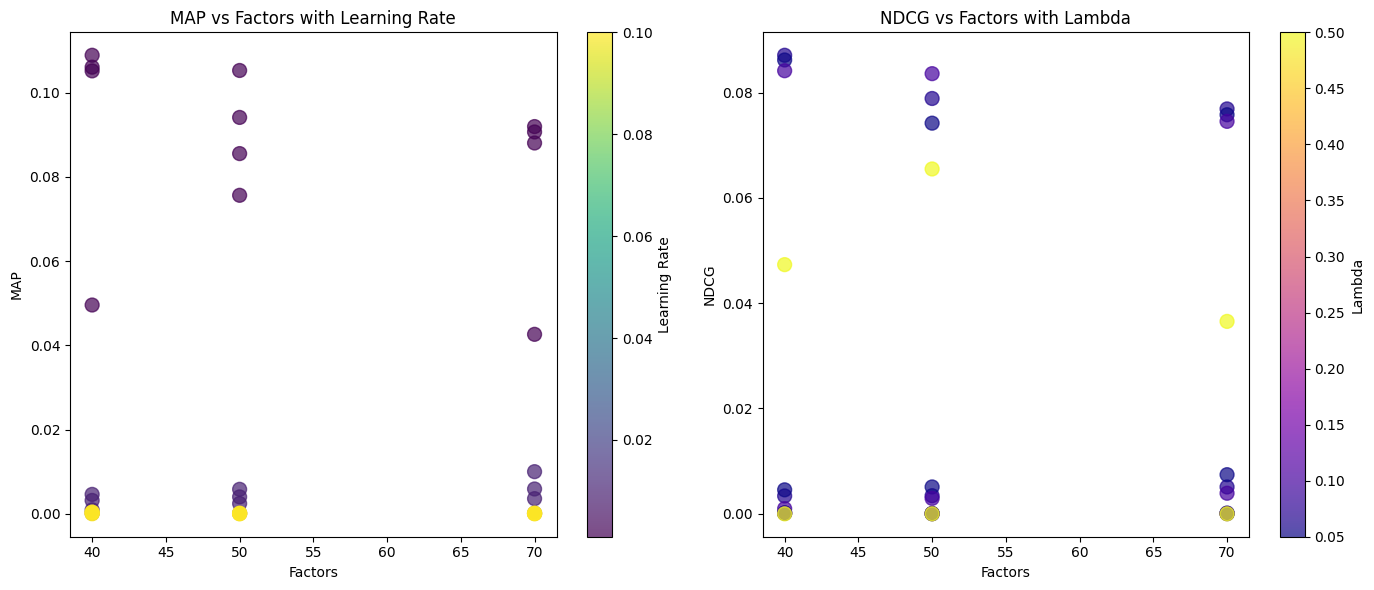

In [ ]:
# Convertir a numpy arrays para facilitar el manejo
results_map = np.array(results_map)
results_ndcg = np.array(results_ndcg)

# Extraer valores para graficar
factors = results_map[:, 0]
learning_rates = results_map[:, 1]
lambdas = results_map[:, 2]
map_scores = results_map[:, 3]
ndcg_scores = results_ndcg[:, 3]

# Crear gráficos
plt.figure(figsize=(14, 6))

# Gráfico de MAP
plt.subplot(1, 2, 1)
sc = plt.scatter(factors, map_scores, c=learning_rates, s=100, cmap='viridis', alpha=0.7)
plt.colorbar(sc, label='Learning Rate')
plt.xlabel('Factors')
plt.ylabel('MAP')
plt.title('MAP vs Factors with Learning Rate')

# Gráfico de NDCG
plt.subplot(1, 2, 2)
sc = plt.scatter(factors, ndcg_scores, c=lambdas, s=100, cmap='plasma', alpha=0.7)
plt.colorbar(sc, label='Lambda')
plt.xlabel('Factors')
plt.ylabel('NDCG')
plt.title('NDCG vs Factors with Lambda')

plt.tight_layout()
plt.show()

In [ ]:
mySVD = pyreclab.SVD(dataset='dataset_tarea1/training_set_filtered.csv', dlmchar=b'\t', header=False, usercol=0, itemcol=1, ratingcol=2)
# Iniciar el temporizador
start_time = time.time()
# Obtener el uso de CPU antes del entrenamiento
cpu_usage_before = psutil.cpu_percent(interval=None)
# Obtener información de memoria antes del entrenamiento
mem_info_before = psutil.virtual_memory().used

mySVD.train(factors=40, maxiter=90, lr=0.001, lamb=0.065)

# Obtener información de memoria después del entrenamiento
mem_info_after = psutil.virtual_memory().used
# Detener el temporizador
end_time = time.time()
# Obtener el uso de CPU después del entrenamiento
cpu_usage_after = psutil.cpu_percent(interval=None)

print(f"Tiempo de entrenamiento: {end_time - start_time} segundos")
print(f"Memoria utilizada: {(mem_info_after - mem_info_before) / (1024 ** 2)} MB")
print(f"Uso de CPU: {cpu_usage_after - cpu_usage_before}%")

Tiempo de entrenamiento: 1.592106819152832 segundos
Memoria utilizada: -53.21484375 MB
Uso de CPU: 1.8999999999999986%


In [ ]:
top_n = 10

recommendList, maprec, ndcg = mySVD.testrec(input_file='dataset_tarea1/validation_set.csv',
                                          dlmchar=b',',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=3,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAP: 0.0985795263269075
NDCG@10: 0.08130179256071887


In [ ]:
ranking_SVD = {}
recall_score = 0
diversidad = 0

for user_id in ranking_template_fill.keys():
    recommendations = mySVD.recommend(str(user_id), 10, includeRated=False)
    ranking = [int(r) for r in recommendations]
    recall = mySVD.recall(str(user_id), ranking)
    diversidad += calcular_diversidad(item_styles, ranking)
    if not np.isnan(recall):
      recall_score += recall
    ranking_SVD[user_id] = recommendations

print('Recall del dataset: {}'.format(recall_score / len(ranking_template_fill)))
print('Diversidad: {}'.format(diversidad / len(ranking_template_fill)))

Recall del dataset: 0.0
Diversidad: 0.36093189964157246


In [ ]:
novedad = calcular_novedad(ranking_SVD)
print('Novedad: {}'.format(novedad))

Novedad: 6.825851486326033


In [ ]:
with open('dataset_tarea1/ranking_template_fill_SVD.json', 'w') as file:
    json.dump(ranking_SVD, file, indent=2)

## 2.3. ALS

In [ ]:
user_items = {}
itemset = set()

for row in training_set.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []

    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)

matrix = sparse.csr_matrix(sparse_matrix.T)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
user_item_matrix = matrix.T.tocsr()

In [ ]:
def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rel_vector):
    return np.mean([average_precision(r) for r in rel_vector])

In [ ]:
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(rel_vector, k):
    idcg = dcg_at_k(sorted(rel_vector, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(rel_vector, k) / idcg

In [ ]:
def recall_at_k(relevant_items, recommended_items, k):
    relevant_items = set(relevant_items)
    recommended_items = set(recommended_items[:k])
    intersection = relevant_items.intersection(recommended_items)
    if len(relevant_items) > 0:
      recall = len(intersection) / len(relevant_items)
    else:
      recall = 0
    return recall

In [ ]:
def evaluate_model(model, user_items_test, n):
  mean_map = 0.
  mean_ndcg = 0.

  for u in user_items_test.keys():
    rec = model.recommend(u, user_item_matrix[u], n)[0]
    rel_vector = [np.isin(user_items_test[u], rec, assume_unique=True).astype(int)]
    mean_map += mean_average_precision(rel_vector)
    mean_ndcg += ndcg_at_k(rel_vector, n)

  mean_map /= len(user_items_test)
  mean_ndcg /= len(user_items_test)

  return mean_map, mean_ndcg

In [ ]:
from implicit.als import AlternatingLeastSquares
import numpy as np

# Definir el rango de factores y otros parámetros que quieres probar
factors_list = [10, 30, 50, 70, 90]
iterations = 100
best_map = -1  # Inicializar con un valor bajo para MAP
best_ndcg = -1  # Inicializar con un valor bajo para NDCG
best_factors = None
top_n = 10 # Número de recomendaciones a considerar para la evaluación
map_scores = []
ndcg_scores = []


# Evaluar diferentes combinaciones de factores
for factors in factors_list:
    # Crear el modelo ALS con la combinación actual de hiperparámetros
    model = AlternatingLeastSquares(factors=factors, iterations=iterations)

    # Ajustar el modelo con la matriz de interacciones
    model.fit(user_item_matrix)

    # Evaluar el modelo con la función personalizada
    user_item_valid = validation_set.groupby('userID')['itemID'].apply(list).to_dict()
    mean_map, mean_ndcg = evaluate_model(model, user_item_valid, top_n)

    map_scores.append(mean_map)
    ndcg_scores.append(mean_ndcg)

    # Imprimir las métricas para cada combinación
    print(f"Factors: {factors} | MAP: {mean_map:.4f} | NDCG: {mean_ndcg:.4f}")

    # Comparar y guardar los mejores resultados
    if mean_map > best_map and mean_ndcg > best_ndcg:
        best_map = mean_map
        best_ndcg = mean_ndcg
        best_factors = factors

# Mostrar la mejor combinación de factores
print(f"Mejor combinación de factores: {best_factors} con MAP: {best_map:.4f} y NDCG: {best_ndcg:.4f}")

/usr/local/lib/python3.10/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 10 | MAP: 0.0003 | NDCG: 0.0003


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 30 | MAP: 0.0003 | NDCG: 0.0006


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 50 | MAP: 0.0026 | NDCG: 0.0035


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 70 | MAP: 0.0031 | NDCG: 0.0047


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 90 | MAP: 0.0020 | NDCG: 0.0029
Mejor combinación de factores: 70 con MAP: 0.0031 y NDCG: 0.0047


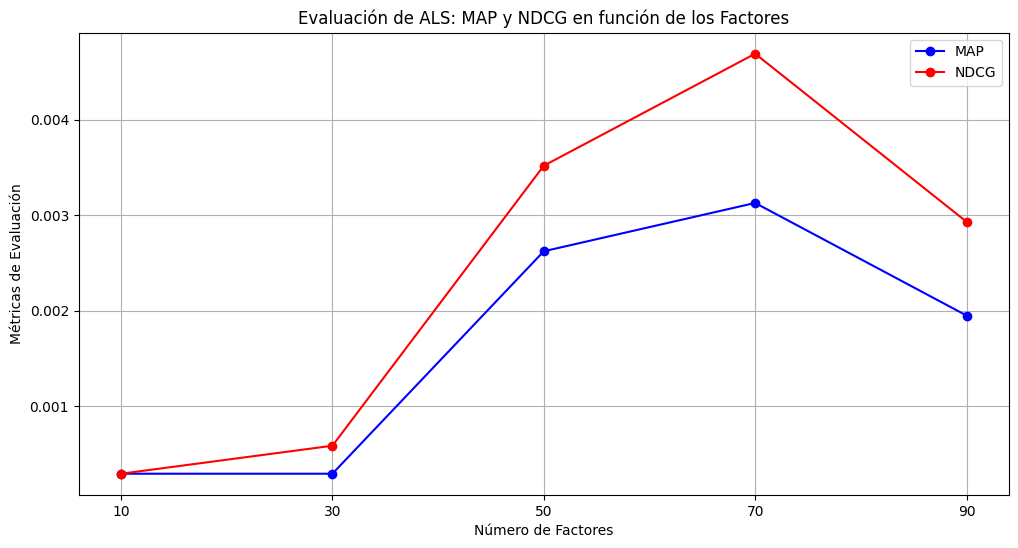

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(factors_list, map_scores, marker='o', linestyle='-', color='b', label='MAP')
plt.plot(factors_list, ndcg_scores, marker='o', linestyle='-', color='r', label='NDCG')

# Configurar el gráfico
plt.title('Evaluación de ALS: MAP y NDCG en función de los Factores')
plt.xlabel('Número de Factores')
plt.ylabel('Métricas de Evaluación')
plt.xticks(factors_list)  # Mostrar solo los valores de factores en el eje x
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()


In [ ]:
myALS = implicit.als.AlternatingLeastSquares(factors=70, iterations=100)
# Iniciar el temporizador
start_time = time.time()
# Obtener información de memoria antes del entrenamiento
mem_info_before = psutil.virtual_memory().used
# Obtener el uso de CPU antes del entrenamiento
cpu_usage_before = psutil.cpu_percent(interval=None)

myALS.fit(user_item_matrix)

# Obtener información de memoria después del entrenamiento
mem_info_after = psutil.virtual_memory().used
# Detener el temporizador
end_time = time.time()
# Obtener el uso de CPU después del entrenamiento
cpu_usage_after = psutil.cpu_percent(interval=None)

print(f"Tiempo de entrenamiento: {end_time - start_time} segundos")
print(f"Memoria utilizada: {(mem_info_after - mem_info_before) / (1024 ** 2)} MB")
print(f"Uso de CPU: {cpu_usage_after - cpu_usage_before}%")

  0%|          | 0/100 [00:00<?, ?it/s]

Tiempo de entrenamiento: 14.309739112854004 segundos
Memoria utilizada: -19.19140625 MB
Uso de CPU: 7.599999999999994%


In [ ]:
top_n = 10

user_item_valid = validation_set.groupby('userID')['itemID'].apply(list).to_dict()
map, ndcg = evaluate_model(myALS, user_item_valid, top_n)

print('MAP: {}\nNDCG@{}: {}'.format(map, top_n, ndcg))

MAP: 0.003658706884513336
NDCG@10: 0.00469208211143695


In [ ]:
ranking_ALS = {}
recall_score = 0
diversidad = 0

for user_id in ranking_template_fill.keys():
    recommendations = myALS.recommend(userid=int(user_id), user_items=user_item_matrix[int(user_id)], N=10)[0]
    ranking = [int(r) for r in recommendations]
    user_ratings = validation_set[validation_set['userID'] == user_id]
    average_rating = user_ratings['rating'].mean()
    relevants_items = user_ratings['itemID'].tolist()
    recall_score += recall_at_k(relevants_items, recommendations, 10)
    diversidad += calcular_diversidad(item_styles, ranking)
    ranking_ALS[user_id] = list(recommendations.astype(str))

print('Recall del dataset: {}'.format(recall_score / len(ranking_template_fill)))
print('Diversidad: {}'.format(diversidad / len(ranking_template_fill)))

Recall del dataset: 0.0
Diversidad: 0.01259600614439328


In [ ]:
novedad = calcular_novedad(ranking_ALS)
print('Novedad: {}'.format(novedad))

Novedad: 0.056352239474939475


In [ ]:
with open('dataset_tarea1/ranking_template_fill_ALS.json', 'w') as file:
    json.dump(ranking_ALS, file, indent=2)

## 2.4. BPR

In [ ]:
from implicit.bpr import BayesianPersonalizedRanking
import numpy as np

In [ ]:
from implicit.bpr import BayesianPersonalizedRanking
import matplotlib.pyplot as plt

# Definir los rangos de parámetros que quieres probar
factors_list = [50, 60, 70, 100]
learning_rates = [0.001, 0.01, 0.1]
regularizations = [0.001, 0.01, 0.1]
top_n = 10  # Número de recomendaciones a considerar para la evaluación

# Inicializar variables para almacenar los mejores resultados
best_map = -1
best_ndcg = -1
best_params = None

# Listas para recopilar resultados
results = []

# Evaluar diferentes combinaciones de parámetros
for factors in factors_list:
    for learning_rate in learning_rates:
        for regularization in regularizations:
            # Crear el modelo BPR con la combinación actual de hiperparámetros
            model = BayesianPersonalizedRanking(
                factors=factors,
                learning_rate=learning_rate,
                regularization=regularization,
                iterations=100
            )

            # Ajustar el modelo con la matriz de interacciones
            model.fit(user_item_matrix)

            # Evaluar el modelo con la función personalizada
            user_item_valid = validation_set.groupby('userID')['itemID'].apply(list).to_dict()
            mean_map, mean_ndcg = evaluate_model(model, user_item_valid, top_n)

            # Almacenar resultados
            results.append((factors, learning_rate, regularization, mean_map, mean_ndcg))

            # Imprimir las métricas para cada combinación
            print(f"Factors: {factors} | Learning Rate: {learning_rate} | Regularization: {regularization} | MAP: {mean_map:.4f} | NDCG: {mean_ndcg:.4f}")

            # Comparar y guardar los mejores resultados
            if mean_map > best_map and mean_ndcg > best_ndcg:
                best_map = mean_map
                best_ndcg = mean_ndcg
                best_params = (factors, learning_rate, regularization)

# Mostrar la mejor combinación de parámetros
print(f"Mejor combinación de parámetros: Factors={best_params[0]}, Learning Rate={best_params[1]}, Regularization={best_params[2]} con MAP: {best_map:.4f} y NDCG: {best_ndcg:.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 50 | Learning Rate: 0.001 | Regularization: 0.001 | MAP: 0.0000 | NDCG: 0.0000


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 50 | Learning Rate: 0.001 | Regularization: 0.01 | MAP: 0.0000 | NDCG: 0.0000


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 50 | Learning Rate: 0.001 | Regularization: 0.1 | MAP: 0.0000 | NDCG: 0.0000


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 50 | Learning Rate: 0.01 | Regularization: 0.001 | MAP: 0.0020 | NDCG: 0.0026


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 50 | Learning Rate: 0.01 | Regularization: 0.01 | MAP: 0.0004 | NDCG: 0.0006


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 50 | Learning Rate: 0.01 | Regularization: 0.1 | MAP: 0.0000 | NDCG: 0.0000


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 50 | Learning Rate: 0.1 | Regularization: 0.001 | MAP: 0.0007 | NDCG: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 50 | Learning Rate: 0.1 | Regularization: 0.01 | MAP: 0.0003 | NDCG: 0.0006


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 50 | Learning Rate: 0.1 | Regularization: 0.1 | MAP: 0.0003 | NDCG: 0.0003


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 60 | Learning Rate: 0.001 | Regularization: 0.001 | MAP: 0.0000 | NDCG: 0.0000


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 60 | Learning Rate: 0.001 | Regularization: 0.01 | MAP: 0.0000 | NDCG: 0.0000


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 60 | Learning Rate: 0.001 | Regularization: 0.1 | MAP: 0.0003 | NDCG: 0.0003


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 60 | Learning Rate: 0.01 | Regularization: 0.001 | MAP: 0.0026 | NDCG: 0.0044


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 60 | Learning Rate: 0.01 | Regularization: 0.01 | MAP: 0.0007 | NDCG: 0.0012


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 60 | Learning Rate: 0.01 | Regularization: 0.1 | MAP: 0.0004 | NDCG: 0.0009


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 60 | Learning Rate: 0.1 | Regularization: 0.001 | MAP: 0.0003 | NDCG: 0.0003


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 60 | Learning Rate: 0.1 | Regularization: 0.01 | MAP: 0.0004 | NDCG: 0.0015


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 60 | Learning Rate: 0.1 | Regularization: 0.1 | MAP: 0.0001 | NDCG: 0.0006


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 70 | Learning Rate: 0.001 | Regularization: 0.001 | MAP: 0.0000 | NDCG: 0.0000


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 70 | Learning Rate: 0.001 | Regularization: 0.01 | MAP: 0.0000 | NDCG: 0.0000


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 70 | Learning Rate: 0.001 | Regularization: 0.1 | MAP: 0.0000 | NDCG: 0.0000


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 70 | Learning Rate: 0.01 | Regularization: 0.001 | MAP: 0.0045 | NDCG: 0.0056


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 70 | Learning Rate: 0.01 | Regularization: 0.01 | MAP: 0.0050 | NDCG: 0.0062


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 70 | Learning Rate: 0.01 | Regularization: 0.1 | MAP: 0.0000 | NDCG: 0.0000


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 70 | Learning Rate: 0.1 | Regularization: 0.001 | MAP: 0.0003 | NDCG: 0.0003


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 70 | Learning Rate: 0.1 | Regularization: 0.01 | MAP: 0.0016 | NDCG: 0.0023


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 70 | Learning Rate: 0.1 | Regularization: 0.1 | MAP: 0.0006 | NDCG: 0.0006


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 100 | Learning Rate: 0.001 | Regularization: 0.001 | MAP: 0.0000 | NDCG: 0.0000


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 100 | Learning Rate: 0.001 | Regularization: 0.01 | MAP: 0.0000 | NDCG: 0.0000


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 100 | Learning Rate: 0.001 | Regularization: 0.1 | MAP: 0.0000 | NDCG: 0.0000


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 100 | Learning Rate: 0.01 | Regularization: 0.001 | MAP: 0.0040 | NDCG: 0.0056


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 100 | Learning Rate: 0.01 | Regularization: 0.01 | MAP: 0.0023 | NDCG: 0.0035


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 100 | Learning Rate: 0.01 | Regularization: 0.1 | MAP: 0.0000 | NDCG: 0.0000


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 100 | Learning Rate: 0.1 | Regularization: 0.001 | MAP: 0.0006 | NDCG: 0.0006


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 100 | Learning Rate: 0.1 | Regularization: 0.01 | MAP: 0.0006 | NDCG: 0.0015


  0%|          | 0/100 [00:00<?, ?it/s]

Factors: 100 | Learning Rate: 0.1 | Regularization: 0.1 | MAP: 0.0003 | NDCG: 0.0003
Mejor combinación de parámetros: Factors=70, Learning Rate=0.01, Regularization=0.01 con MAP: 0.0050 y NDCG: 0.0062


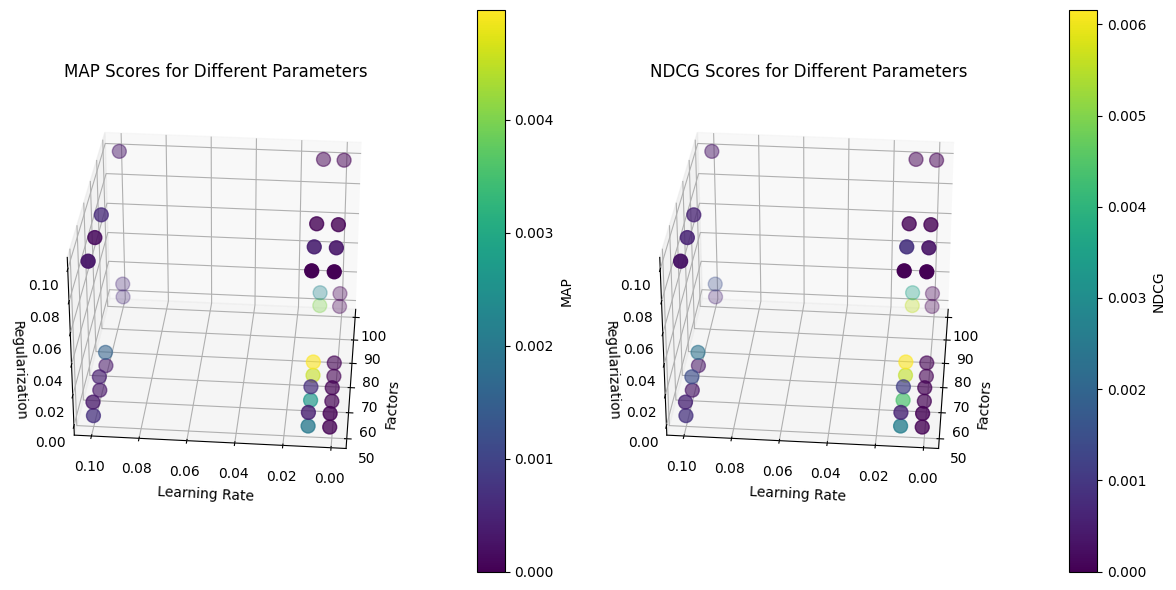

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Preparar los datos para el gráfico 3D
factors = [r[0] for r in results]
learning_rates = [r[1] for r in results]
regularizations = [r[2] for r in results]
map_scores = [r[3] for r in results]
ndcg_scores = [r[4] for r in results]

# Crear un gráfico 3D para MAP
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(factors, learning_rates, regularizations, c=map_scores, cmap='viridis', s=100)
ax1.set_title('MAP Scores for Different Parameters')
ax1.set_xlabel('Factors')
ax1.set_ylabel('Learning Rate')
ax1.set_zlabel('Regularization')
ax1.view_init(30, 185)  # Ajusta la perspectiva del gráfico
cbar1 = plt.colorbar(ax1.collections[0], ax=ax1, pad=0.1)
cbar1.set_label('MAP')

# Crear un gráfico 3D para NDCG
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(factors, learning_rates, regularizations, c=ndcg_scores, cmap='viridis', s=100)
ax2.set_title('NDCG Scores for Different Parameters')
ax2.set_xlabel('Factors')
ax2.set_ylabel('Learning Rate')
ax2.set_zlabel('Regularization')
ax2.view_init(30, 185)  # Ajusta la perspectiva del gráfico
cbar2 = plt.colorbar(ax2.collections[0], ax=ax2, pad=0.1)
cbar2.set_label('NDCG')

plt.tight_layout()
plt.show()


In [ ]:
myBPR = implicit.bpr.BayesianPersonalizedRanking(factors=70, learning_rate=0.01, regularization=0.1, iterations=100)
# Iniciar el temporizador
start_time = time.time()
# Obtener información de memoria antes del entrenamiento
mem_info_before = psutil.virtual_memory().used
# Obtener el uso de CPU antes del entrenamiento
cpu_usage_before = psutil.cpu_percent(interval=None)

myBPR.fit(user_item_matrix)

# Obtener información de memoria después del entrenamiento
mem_info_after = psutil.virtual_memory().used
# Detener el temporizador
end_time = time.time()
# Obtener el uso de CPU después del entrenamiento
cpu_usage_after = psutil.cpu_percent(interval=None)

print(f"Tiempo de entrenamiento: {end_time - start_time} segundos")
print(f"Memoria utilizada: {(mem_info_after - mem_info_before) / (1024 ** 2)} MB")
print(f"Uso de CPU: {cpu_usage_after - cpu_usage_before}%")

  0%|          | 0/100 [00:00<?, ?it/s]

Tiempo de entrenamiento: 2.5150904655456543 segundos
Memoria utilizada: -1.44921875 MB
Uso de CPU: 11.400000000000006%


In [ ]:
ranking_BPR = {}
recall_score = 0
novedad = 0

for user_id in ranking_template_fill.keys():
    recommendations = myBPR.recommend(userid=int(user_id), user_items=user_item_matrix[int(user_id)], N=10)[0]
    ranking = [int(r) for r in recommendations]
    user_ratings = validation_set[validation_set['userID'] == user_id]
    average_rating = user_ratings['rating'].mean()
    relevants_items = user_ratings['itemID'].tolist()
    recall_score += recall_at_k(relevants_items, recommendations, 10)
    diversidad += calcular_diversidad(item_styles, ranking)
    ranking_BPR[user_id] = list(recommendations.astype(str))

print('Recall del dataset: {}'.format(recall_score / len(ranking_template_fill)))
print('Diversidad: {}'.format(diversidad / len(ranking_template_fill)))

Recall del dataset: 0.0
Diversidad: 0.01259600614439328


In [ ]:
novedad = calcular_novedad(ranking_BPR)
print('Novedad: {}'.format(novedad))

Novedad: 0.0


In [ ]:
with open('dataset_tarea1/ranking_template_fill_BPR.json', 'w') as file:
    json.dump(ranking_BPR, file, indent=2)

## 2.5. Factorization Machines

In [ ]:
!pip3 install Cython
!pip3 install fastFM

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastFM: filename=fastFM-0.2.10-cp310-cp310-linux_x86_64.whl size=591782 sha256=6ebd625d3df6c1901044f43554cab6e6dee33fe3d119a78eab6847ec0076f1a5
  Stored in directory: /root/.cache/pip/wheels/93/92/52/2da7997fcb7a7ce9042ff3b33836ef0c2fd47aa95382d7a113
Successfully built fastFM


In [ ]:
import fastFM
from fastFM.datasets import make_user_item_regression
from sklearn.model_selection import train_test_split
from fastFM import sgd
from fastFM import als
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
from fastFM import mcmc
import functools as fct
import itertools as itools
import random, scipy

In [ ]:
def get_single_entries_in_fm_input_format(data, itemlist):

    '''Cree el formato de entrada necesario (datos, (fila, columna)) para la matriz csc para
    las entradas individuales en los datos. Cada entrada ocuparía una fila. Esto significa que
    daría como resultado una matriz csc con dimensión (| datos | x | lista de elementos |).
    '''

    column = len(itemlist)
    row = len(data)
    shape = (row, column)

    row_inds = np.zeros(len(data), dtype=int)
    col_inds = np.zeros(len(data), dtype=int)
    datalist = np.zeros(len(data), dtype=float)

    for i in range(len(data)):
        item = data[i]
        val = 1
        datalist[i] = val

        # ubica su posición en la lista de elementos, arroja un error si el elemento no es un
        # artículo posible
        col_ind = np.where(itemlist==item)[0]

        # no deben ser elementos duplicados en la lista de elementos
        assert len(col_ind) == 1
        col_ind = col_ind[0]
        row_ind = i

        col_inds[i] = col_ind
        row_inds[i] = row_ind

    return datalist, row_inds, col_inds, shape


def get_multi_entries_in_fm_input_format(data, itemlist, norm_func=None):

    '''Cree el formato de entrada necesario (datos, (fila, columna)) para la matriz csc para
    las entradas múltiples en los datos. Cada conjunto de entradas múltiples ocuparía una fila.
    Esto significa que daría como resultado una matriz csc con dimensión
    (| conjuntos de entradas en datos | x | lista de elementos |).
    '''

    column = len(itemlist)

    # número de conjuntos de entradas en los datos
    row = len(data)
    shape = (row, column)

    # numero de datos
    num_of_data = fct.reduce(lambda x, y: x + len(y), data, 0)
    row_inds = np.zeros(num_of_data, dtype=int)
    col_inds = np.zeros(num_of_data, dtype=int)
    datalist = np.zeros(num_of_data, dtype=float)
    cnt = 0
    for i in range(len(data)):
        multi_entry = data[i]

        if norm_func != None:
            # función que recibe el tamaño del multi_entry para decidir cómo normalizarlo
            val = norm_func(len(multi_entry))
        else:
            # asignación de valor binario por defecto
            val = 1 if len(multi_entry) > 0 else 0

        # para cada entrada en multi_entry, ubique su posición en la lista de elementos,
        # arroja error si el elemento no es un elemento posible
        # todas las entradas permanecen en la misma fila
        row_ind = i
        for item in multi_entry:
            col_ind = np.where(itemlist==item)[0]
            assert len(col_ind) == 1
            col_ind = col_ind[0]

            datalist[cnt] = val
            col_inds[cnt] = col_ind
            row_inds[cnt] = row_ind

            # actualiza contador
            cnt += 1

    return datalist, row_inds, col_inds, shape

In [ ]:
beerlist = training_set.sort_values('itemID')['itemID'].unique()
userlist = training_set.sort_values('userID')['userID'].unique()
stylelist = training_set.sort_values('styleID')['styleID'].unique()

# usuarios que dieron ratings
user_data = training_set['userID'].values

# items que recibieron ratings
beer_data = training_set['itemID'].values

# data de estilo de cerveza
styles_data = training_set['styleID'].values

# target vector: ratings
rating_data = training_set['rating'].values


# convertir a formato fastFM utilizando funciones de arriba
user_datalist, user_row_inds, user_col_inds, user_shape = get_single_entries_in_fm_input_format(data=user_data,
                                                                                                itemlist=userlist)

beer_datalist, beer_row_inds, beer_col_inds, beer_shape = get_single_entries_in_fm_input_format(data=beer_data,
                                                                                                   itemlist=beerlist)

style_datalist, style_row_inds, style_col_inds, style_shape = get_single_entries_in_fm_input_format(data=styles_data,
                                                                                                   itemlist=stylelist)

# Concatena las dos columnas cambiando los índices de las columnas relacionadas con beer.
# cambiar por el número de columnas en las columnas de usuario
shift_by = len(userlist)
beer_col_inds += shift_by
beer_col_inds += shift_by

# concatena los datos (agregamos item_styles)
datalist = np.append(user_datalist, [beer_datalist, style_datalist])
row_inds = np.append(user_row_inds, [beer_row_inds, style_row_inds])
col_inds = np.append(user_col_inds, [beer_col_inds,style_col_inds])

# asegúrese de que ambos conjuntos de características tengan el mismo número de filas
print('User feature set shape: {}\nItem feature set shape: {}\nStyle feature set shape: {}'.format(user_shape, beer_shape, style_shape))

assert user_shape[0] == beer_shape[0]
shape = (user_shape[0], user_shape[0] + beer_shape[0] + style_shape[0])
print('Dimension of FM input: {}'.format(shape))

X = csc_matrix((datalist, (row_inds, col_inds)), shape=shape)
y = rating_data

User feature set shape: (35534, 8320)
Item feature set shape: (35534, 1692)
Style feature set shape: (35534, 202)
Dimension of FM input: (35534, 106602)


In [ ]:
fm = als.FMRegression(n_iter=1000, init_stdev=0.1, rank=10, l2_reg_w=0.1, l2_reg_V=0.5)
# Iniciar el temporizador
start_time = time.time()
# Obtener el uso de CPU antes del entrenamiento
cpu_usage_before = psutil.cpu_percent(interval=None)
# Obtener información de memoria antes del entrenamiento
mem_info_before = psutil.virtual_memory().used

fm.fit(X, y)

# Obtener información de memoria después del entrenamiento
mem_info_after = psutil.virtual_memory().used
# Detener el temporizador
end_time = time.time()
# Obtener el uso de CPU después del entrenamiento
cpu_usage_after = psutil.cpu_percent(interval=None)

print(f"Tiempo de entrenamiento: {end_time - start_time} segundos")
print(f"Memoria utilizada: {(mem_info_after - mem_info_before) / (1024 ** 2)} MB")
print(f"Uso de CPU: {cpu_usage_after - cpu_usage_before}%")

Tiempo de entrenamiento: 65.96170043945312 segundos
Memoria utilizada: 368.9140625 MB
Uso de CPU: 19.700000000000003%


In [ ]:
beerlist = training_set.sort_values('itemID')['itemID'].unique()
userlist = training_set.sort_values('userID')['userID'].unique()
stylelist = training_set.sort_values('styleID')['styleID'].unique()

# usuarios que dieron ratings
user_data = training_set['userID'].values

# items que recibieron ratings
beer_data = training_set['itemID'].values

# data de estilo de cerveza
styles_data = training_set['styleID'].values

# target vector: ratings
rating_data = training_set['rating'].values


# convertir a formato fastFM utilizando funciones de arriba
user_datalist, user_row_inds, user_col_inds, user_shape = get_single_entries_in_fm_input_format(data=user_data,
                                                                                                itemlist=userlist)

beer_datalist, beer_row_inds, beer_col_inds, beer_shape = get_single_entries_in_fm_input_format(data=beer_data,
                                                                                                   itemlist=beerlist)

style_datalist, style_row_inds, style_col_inds, style_shape = get_single_entries_in_fm_input_format(data=styles_data,
                                                                                                   itemlist=stylelist)

# Concatena las dos columnas cambiando los índices de las columnas relacionadas con beer.
# cambiar por el número de columnas en las columnas de usuario
shift_by = len(userlist)
beer_col_inds += shift_by
beer_col_inds += shift_by

# concatena los datos (agregamos item_styles)
datalist = np.append(user_datalist, [beer_datalist, style_datalist])
row_inds = np.append(user_row_inds, [beer_row_inds, style_row_inds])
col_inds = np.append(user_col_inds, [beer_col_inds,style_col_inds])

# asegúrese de que ambos conjuntos de características tengan el mismo número de filas
print('User feature set shape: {}\nItem feature set shape: {}\nStyle feature set shape: {}'.format(user_shape, beer_shape, style_shape))

assert user_shape[0] == beer_shape[0]
shape = (user_shape[0], user_shape[0] + beer_shape[0] + style_shape[0])
print('Dimension of FM input: {}'.format(shape))

X = csc_matrix((datalist, (row_inds, col_inds)), shape=shape)
y = rating_data

User feature set shape: (35534, 8320)
Item feature set shape: (35534, 1692)
Style feature set shape: (35534, 202)
Dimension of FM input: (35534, 106602)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
y_pred = fm.predict(X_test)

In [ ]:
error_als = mean_squared_error(y_test, y_pred)
print('Mean squared error under ALS: {}'.format(error_als))

Mean squared error under ALS: 0.02949238228005891


In [ ]:
fm_sgd = sgd.FMRegression(n_iter=10000000, init_stdev=0.01, rank=10, random_state=123,
                              l2_reg_w=0.1, l2_reg_V=0.5, step_size=0.01)
fm_sgd.fit(X_train, y_train)
y_pred_sgd = fm_sgd.predict(X_test)

In [ ]:
error_sgd = mean_squared_error(y_test, y_pred_sgd)
print('Mean squared error under SGD: {}'.format(error_sgd))

Mean squared error under SGD: 0.47594803496117166
